In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os
import rasterio

In [47]:
# Define the geographic boundaries for the UK
# The mainland areas lie between latitudes 49 N and 59 N (the Shetland Islands reach to nearly 61 N), and longitudes 8 W to 2 E.
min_lon, min_lat, max_lon, max_lat = -9, 34, 32, 72
GEO_BOUND_UK = (min_lon, min_lat, max_lon, max_lat)

min_lon, min_lat, max_lon, max_lat = -31, 34, 40, 72
GEO_BOUND_EU = (min_lon, min_lat, max_lon, max_lat)

min_lon, min_lat, max_lon, max_lat = -141, 42, -52, 83

# 1. Copernicus Daily FWI in UK

# 1.1 FWI Data Loading

Source:https://cds.climate.copernicu.eu/cdsapp#!/dataset/cems-fire-historical-v1?tab=overview

In [18]:
# os.path.exists('../../climada_petals/data/wildfire/2001_fwi_fire_intensity_expriment')
os.path.exists('../../climada_petals/data/wildfire/copernicus_fwi/interpolated25_netcdf/2013/')

True

In [20]:
# folder = '../../climada_petals/data/wildfire/2001_fwi_fire_intensity_expriment'
folder = '../../climada_petals/data/wildfire/copernicus_fwi/interpolated25_netcdf/2013/'
# fwi2001_filepath = 'fwi2001.grib'
# fwi_ds = xr.open_dataset(os.path.join(folder, fwi2001_filepath), engine='cfgrib')
fwi2001_filepath = 'fwi2013.nc'
fwi_ds = xr.open_dataset(os.path.join(folder, fwi2001_filepath))
fwi_ds

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 365, latitude: 721, longitude: 1440)
Coordinates:
  * time        (time) datetime64[ns] 3kB 2013-01-01 2013-01-02 ... 2013-12-31
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 3kB ...
Data variables:
    fwinx       (time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-06-25T14:48 GRIB to CDM+CF via cfgrib-0.9.9...

# 1.2 Data analysis and change to geodataframe

In [30]:

min_latitude = fwi_ds['latitude'].min().values
max_latitude = fwi_ds['latitude'].max().values

min_longitude = fwi_ds['longitude'].min().values
max_longitude = fwi_ds['longitude'].max().values

print(f"Latitude ranges from {min_latitude} to {max_latitude}")
print(f"Longitude ranges from {min_longitude} to {max_longitude}")

Latitude ranges from -90.0 to 90.0
Longitude ranges from 0.0 to 359.75


In [22]:
fwi_ds['fwinx'].values.shape

(365, 721, 1440)

In [7]:
np.isnan(fwi_ds['fwinx'].values[0]).all()

False

In [31]:
fwi_ds.dims

FrozenMappingWarningOnValuesAccess({'time': 365, 'latitude': 51, 'longitude': 117})

In [23]:
fwi_df = fwi_ds.to_dataframe()
fwi_df.shape

(378957600, 4)

In [27]:
fwi_df.reset_index(inplace=True)

In [26]:
fwi_df

step  surface          valid_time  \
time       latitude longitude                                                
2013-01-01  90.0    0.00      0 days 12:00:00      0.0 2013-01-01 12:00:00   
                    0.25      0 days 12:00:00      0.0 2013-01-01 12:00:00   
                    0.50      0 days 12:00:00      0.0 2013-01-01 12:00:00   
                    0.75      0 days 12:00:00      0.0 2013-01-01 12:00:00   
                    1.00      0 days 12:00:00      0.0 2013-01-01 12:00:00   
...                                       ...      ...                 ...   
2013-12-31 -90.0    358.75    0 days 12:00:00      0.0 2013-12-31 12:00:00   
                    359.00    0 days 12:00:00      0.0 2013-12-31 12:00:00   
                    359.25    0 days 12:00:00      0.0 2013-12-31 12:00:00   
                    359.50    0 days 12:00:00      0.0 2013-12-31 12:00:00   
                    359.75    0 days 12:00:00      0.0 2013-12-31 12:00:00   

                               fwinx  
time       latitude longitude         
2013-01-01  90.0    0.00         NaN  
                    0.25         NaN  
                    0.50         NaN  
                    0.75         NaN  
                    1.00         NaN  
...                              ...  
2013-12-31 -90.0    358.75       NaN  
                    359.00       NaN  
                    359.25       NaN  
                    359.50       NaN  
                    359.75       NaN  

[378957600 rows x 4 columns]

In [28]:
fwi_df.columns

Index(['time', 'latitude', 'longitude', 'step', 'surface', 'valid_time',
       'fwinx'],
      dtype='object')

In [48]:
fwi_df['latitude'].describe()

count    2.177955e+06
mean     3.650000e+01
std      7.359802e+00
min      2.400000e+01
25%      3.000000e+01
50%      3.650000e+01
75%      4.300000e+01
max      4.900000e+01
Name: latitude, dtype: float64

In [38]:
print(min_lon, max_lon)

219 308


In [40]:
fwi_df['longitude'] = (fwi_df['longitude'] - 180) % 360 - 180

In [48]:
fwi_uk_df = fwi_df[(fwi_df['longitude'] >= min_lon) & (fwi_df['longitude'] <= max_lon) & (fwi_df['latitude'] >= min_lat) & (fwi_df['latitude'] <= max_lat)]
fwi_uk_df.shape

(21500325, 7)

In [42]:
# Convert df to GeoDataFrame
# fwi_uk_gdf = gpd.GeoDataFrame(
#     fwi_uk_df, 
#     geometry=gpd.points_from_xy(fwi_uk_df['longitude'], fwi_uk_df['latitude']), 
#     crs='EPSG:4326')

fwi_uk_gdf = gpd.GeoDataFrame(
    fwi_df, 
    geometry=gpd.points_from_xy(fwi_df['longitude'], fwi_df['latitude']), 
    crs='EPSG:4326')

In [49]:
fwi_uk_gdf['time'] = pd.to_datetime(fwi_uk_gdf['time'])
fwi_uk_gdf

,time,latitude,longitude,step,surface,valid_time,fwinx,geometry
0,2013-01-01,90.0,-180.00,0 days 12:00:00,0.0,2013-01-01 12:00:00,NaN,POINT (-180.00000 90.00000)
1,2013-01-01,90.0,-179.75,0 days 12:00:00,0.0,2013-01-01 12:00:00,NaN,POINT (-179.75000 90.00000)
2,2013-01-01,90.0,-179.50,0 days 12:00:00,0.0,2013-01-01 12:00:00,NaN,POINT (-179.50000 90.00000)
3,2013-01-01,90.0,-179.25,0 days 12:00:00,0.0,2013-01-01 12:00:00,NaN,POINT (-179.25000 90.00000)
4,2013-01-01,90.0,-179.00,0 days 12:00:00,0.0,2013-01-01 12:00:00,NaN,POINT (-179.00000 90.00000)
...,...,...,...,...,...,...,...,...
378957595,2013-12-31,-90.0,178.75,0 days 12:00:00,0.0,2013-12-31 12:00:00,NaN,POINT (178.75000 -90.00000)
378957596,2013-12-31,-90.0,179.00,0 days 12:00:00,0.0,2013-12-31 12:00:00,NaN,POINT (179.00000 -90.00000)
378957597,2013-12-31,-90.0,179.25,0 days 12:00:00,0.0,2013-12-31 12:00:00,NaN,POINT (179.25000 -90.00000)
378957598,2013-12-31,-90.0,179.50,0 days 12:00:00,0.0,2013-12-31 12:00:00,NaN,POINT (179.50000 -90.00000)


In [54]:
fwi_uk_gdf.reset_index()['time'].unique()

<DatetimeArray>
['2013-01-01 12:00:00', '2013-01-02 12:00:00', '2013-01-03 12:00:00',
 '2013-01-04 12:00:00', '2013-01-05 12:00:00', '2013-01-06 12:00:00',
 '2013-01-07 12:00:00', '2013-01-08 12:00:00', '2013-01-09 12:00:00',
 '2013-01-10 12:00:00',
 ...
 '2013-12-22 12:00:00', '2013-12-23 12:00:00', '2013-12-24 12:00:00',
 '2013-12-25 12:00:00', '2013-12-26 12:00:00', '2013-12-27 12:00:00',
 '2013-12-28 12:00:00', '2013-12-29 12:00:00', '2013-12-30 12:00:00',
 '2013-12-31 12:00:00']
Length: 365, dtype: datetime64[ns]

In [14]:
save_path = '../../climada_petals/data/wildfire/intermediate/'
fwi_uk_gdf.to_file(os.path.join(save_path, 'fwi_uk_gdf'), driver='GPKG')

# 1.3 Display FWI Data on map of UK on 2001-01

In [50]:
# select FWI Data on map of UK on 2001-01


fwi_uk_2001_01_df = fwi_uk_gdf[fwi_uk_gdf['time'].dt.to_period('D') == '2013-01-05']
fwi_uk_2001_01_df.shape

(1038240, 8)

In [51]:
# Convert df to GeoDataFrame
fwi_uk_2001_01_gdf = gpd.GeoDataFrame(
    fwi_uk_2001_01_df, 
    geometry=gpd.points_from_xy(fwi_uk_2001_01_df['longitude'], fwi_uk_2001_01_df['latitude']), 
    crs='EPSG:4326')

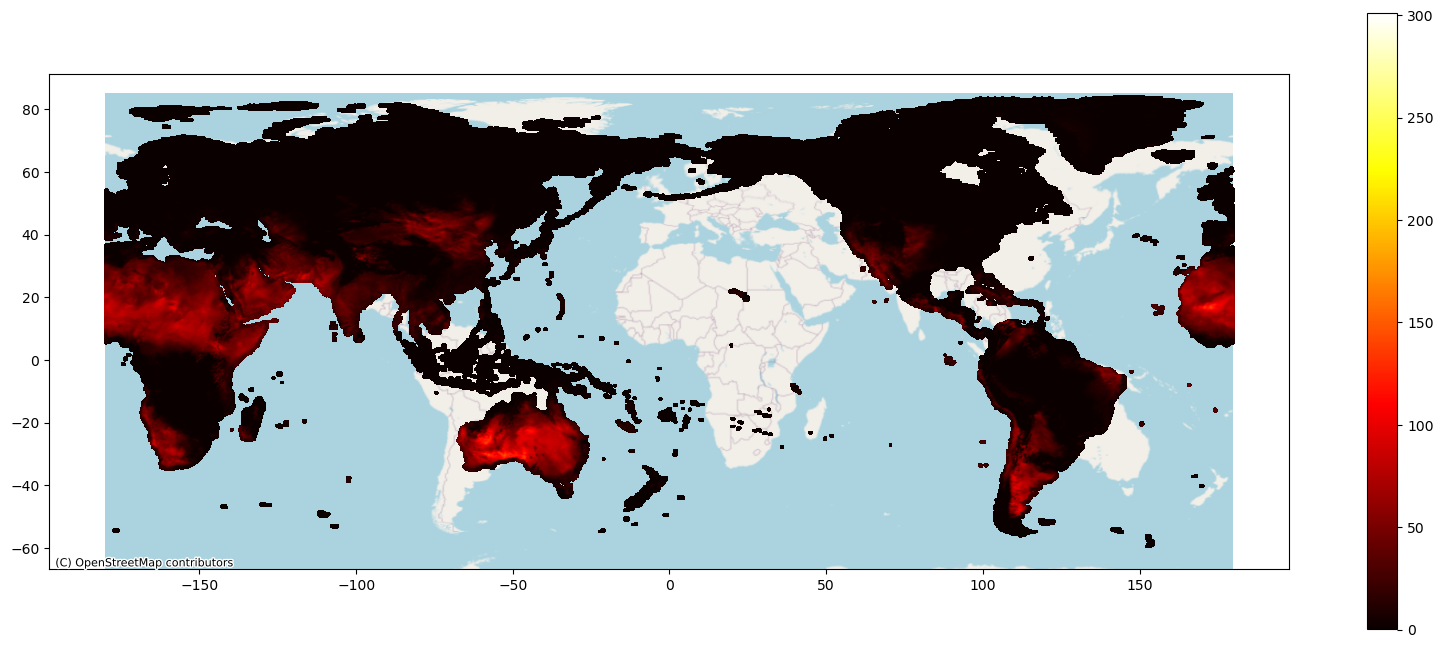

In [52]:

fig, ax = plt.subplots(figsize=(20, 8))
fwi_uk_gdf.plot(ax=ax, column='fwinx', legend=True, cmap='hot', markersize=1)

# Set the extent of the axes to match the spatial extent of your data
# ax.set_xlim(min_lon, max_lon)
# ax.set_ylim(min_lat, max_lat)

ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

# 2. Nasa-FIRMS Daily Fire Intensity Data in UK (many dates are not available)

Source: https://firms.modaps.eosdis.nasa.gov/download/
CRS: EPSG:4326, also known as WGS 84 (https://www.earthdata.nasa.gov/faq/firms-faq#ed-nrt-standard)
Data Description:
-- fire_archive_M-C61_xx = MODIS standard quality Thermal Anomalies / Fire locations 
                        processed by the University of Maryland with a 3-month
                        lag and distributed by FIRMS. These standard data (MCD14ML) 
                        replace the NRT (MCD14DL) files when available.

Data not used:
-- fire_nrt_M-C61_xx = MODIS Near Real Time Thermal Anomalies/Fire locations

# 2.1 Fire Intensity Data Loading

In [5]:
# os.path.exists('../../climada_petals/data/wildfire/2001_fwi_fire_intensity_expriment/fire_intensity_csv/')
os.path.exists('../../climada_petals/data/wildfire/nasa_fire_intensity/2013/')

True

In [7]:
# folder = '../../climada_petals/data/wildfire/2001_fwi_fire_intensity_expriment/fire_intensity_csv/'
folder = '../../climada_petals/data/wildfire/nasa_fire_intensity/2013/'
fire_intensity_filepath = '2013.csv'
fire_intensity_df = pd.read_csv(os.path.join(folder, fire_intensity_filepath))

# fire_intensity_df = pd.read_csv('C:/Users\zhong\Documents\Python Projects\climada_petals\doc\my_scripts\Wildfire_US2018.csv')

# 2.2 Data analysis and change to geodataframe

In [8]:
# Convert df to GeoDataFrame
fire_intensity_gdf = gpd.GeoDataFrame(
    fire_intensity_df, 
    geometry=gpd.points_from_xy(fire_intensity_df['longitude'], fire_intensity_df['latitude']),
    crs='EPSG:4326')

fire_intensity_gdf

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,geometry
0,19.3440,-155.0140,312.1,1.9,1.3,2013-01-01,6,Aqua,MODIS,0,6.03,293.7,18.0,D,1,POINT (-155.01400 19.34400)
1,-6.3796,155.4129,310.5,1.7,1.3,2013-01-01,24,Terra,MODIS,25,6.03,283.5,14.7,D,2,POINT (155.41290 -6.37960)
2,-13.6477,143.0941,320.6,1.9,1.3,2013-01-01,26,Terra,MODIS,20,6.03,296.6,23.6,D,0,POINT (143.09410 -13.64770)
3,-19.3066,139.7623,379.5,2.6,1.5,2013-01-01,28,Terra,MODIS,100,6.03,301.7,555.5,D,0,POINT (139.76230 -19.30660)
4,-19.3065,139.7308,344.2,2.6,1.6,2013-01-01,28,Terra,MODIS,84,6.03,295.7,153.5,D,0,POINT (139.73080 -19.30650)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4248836,-24.8698,147.3602,331.1,2.0,1.4,2013-12-31,2359,Terra,MODIS,44,6.03,306.5,44.0,D,0,POINT (147.36020 -24.86980)
4248837,-24.8651,147.4016,325.6,2.0,1.4,2013-12-31,2359,Terra,MODIS,38,6.03,303.0,25.9,D,0,POINT (147.40160 -24.86510)
4248838,-24.8613,147.3824,342.1,2.0,1.4,2013-12-31,2359,Terra,MODIS,88,6.03,305.3,90.5,D,0,POINT (147.38240 -24.86130)
4248839,-24.8879,147.4029,329.7,2.0,1.4,2013-12-31,2359,Terra,MODIS,70,6.03,304.9,37.2,D,0,POINT (147.40290 -24.88790)


In [9]:
min_latitude = fire_intensity_gdf['latitude'].min()
max_latitude = fire_intensity_gdf['latitude'].max()

min_longitude = fire_intensity_gdf['longitude'].min()
max_longitude = fire_intensity_gdf['longitude'].max()

print(f"Latitude ranges from {min_latitude} to {max_latitude}")
print(f"Longitude ranges from {min_longitude} to {max_longitude}")

Latitude ranges from -71.6986 to 81.7036
Longitude ranges from -179.6394 to 179.5932


In [16]:
fire_intensity_uk_gdf = fire_intensity_gdf[(fire_intensity_gdf['longitude'] >= min_lon) & (fire_intensity_gdf['longitude'] <= max_lon) & (fire_intensity_gdf['latitude'] >= min_lat) & (fire_intensity_gdf['latitude'] <= max_lat)]
# Method 2
# fire_intensity_uk_gdf = fire_intensity_gdf.cx[min_lon:max_lon, min_lat:max_lat]
fire_intensity_uk_gdf.shape

(87268, 16)

In [ ]:
# Ensure 'acq_data' is in datetime format
fire_intensity_gdf['acq_date'] = pd.to_datetime(fire_intensity_gdf['acq_date'])

In [65]:
fire_intensity_uk_gdf.to_file(os.path.join(save_path, 'fire_intensity_uk_gdf'), driver='GPKG')

In [26]:
fire_intensity_uk_2001_01_01_gdf = fire_intensity_uk_gdf[fire_intensity_uk_gdf['acq_date'] == '2001-01-01']
fire_intensity_uk_2001_01_01_gdf.shape

(0, 16)

In [29]:
fire_intensity_uk_gdf

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,geometry
84351,51.4585,0.2016,300.6,1.0,1.0,2001-01-13,1121,Terra,MODIS,40,6.03,277.0,7.6,D,2,POINT (0.20160 51.45850)
123280,51.7088,-2.1441,300.2,1.0,1.0,2001-01-20,1127,Terra,MODIS,32,6.03,274.0,8.1,D,0,POINT (-2.14410 51.70880)
150634,56.0069,-3.6730,312.7,1.0,1.0,2001-01-24,2215,Terra,MODIS,85,6.03,273.6,17.8,N,2,POINT (-3.67300 56.00690)
154790,53.5650,-0.5943,301.6,1.2,1.1,2001-01-25,1145,Terra,MODIS,46,6.03,276.8,9.6,D,2,POINT (-0.59430 53.56500)
164970,51.4635,0.2020,303.0,1.1,1.0,2001-01-27,1134,Terra,MODIS,54,6.03,277.6,10.4,D,2,POINT (0.20200 51.46350)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735167,51.4665,0.2048,303.2,1.0,1.0,2001-12-22,1119,Terra,MODIS,55,6.03,273.4,10.4,D,2,POINT (0.20480 51.46650)
1760094,57.6640,1.1497,312.7,1.4,1.2,2001-12-26,1052,Terra,MODIS,55,6.03,279.8,23.4,D,3,POINT (1.14970 57.66400)
1771486,53.4047,-0.0979,302.3,1.8,1.3,2001-12-28,1041,Terra,MODIS,52,6.03,274.9,22.9,D,0,POINT (-0.09790 53.40470)
1778254,53.5780,-0.6220,308.7,1.0,1.0,2001-12-29,1124,Terra,MODIS,0,6.03,273.3,14.0,D,2,POINT (-0.62200 53.57800)


In [62]:
fire_intensity_uk_gdf['acq_date'].unique()

array(['2001-01-13', '2001-01-20', '2001-01-24', '2001-01-25',
       '2001-01-27', '2001-01-31', '2001-02-06', '2001-02-07',
       '2001-02-13', '2001-02-14', '2001-02-16', '2001-02-17',
       '2001-02-18', '2001-02-19', '2001-02-21', '2001-02-23',
       '2001-02-24', '2001-03-05', '2001-03-06', '2001-03-07',
       '2001-03-13', '2001-03-14', '2001-03-16', '2001-03-19',
       '2001-03-20', '2001-03-22', '2001-03-24', '2001-03-26',
       '2001-03-27', '2001-03-28', '2001-03-30', '2001-03-31',
       '2001-04-01', '2001-04-03', '2001-04-04', '2001-04-05',
       '2001-04-06', '2001-04-08', '2001-04-11', '2001-04-12',
       '2001-04-13', '2001-04-15', '2001-04-16', '2001-04-19',
       '2001-04-20', '2001-04-22', '2001-04-23', '2001-04-26',
       '2001-04-28', '2001-04-29', '2001-04-30', '2001-05-01',
       '2001-05-04', '2001-05-05', '2001-05-06', '2001-05-07',
       '2001-05-08', '2001-05-09', '2001-05-10', '2001-05-11',
       '2001-05-12', '2001-05-13', '2001-05-14', '2001-

# 2.3 Display fire intensity data on map of UK on 2001-01-01

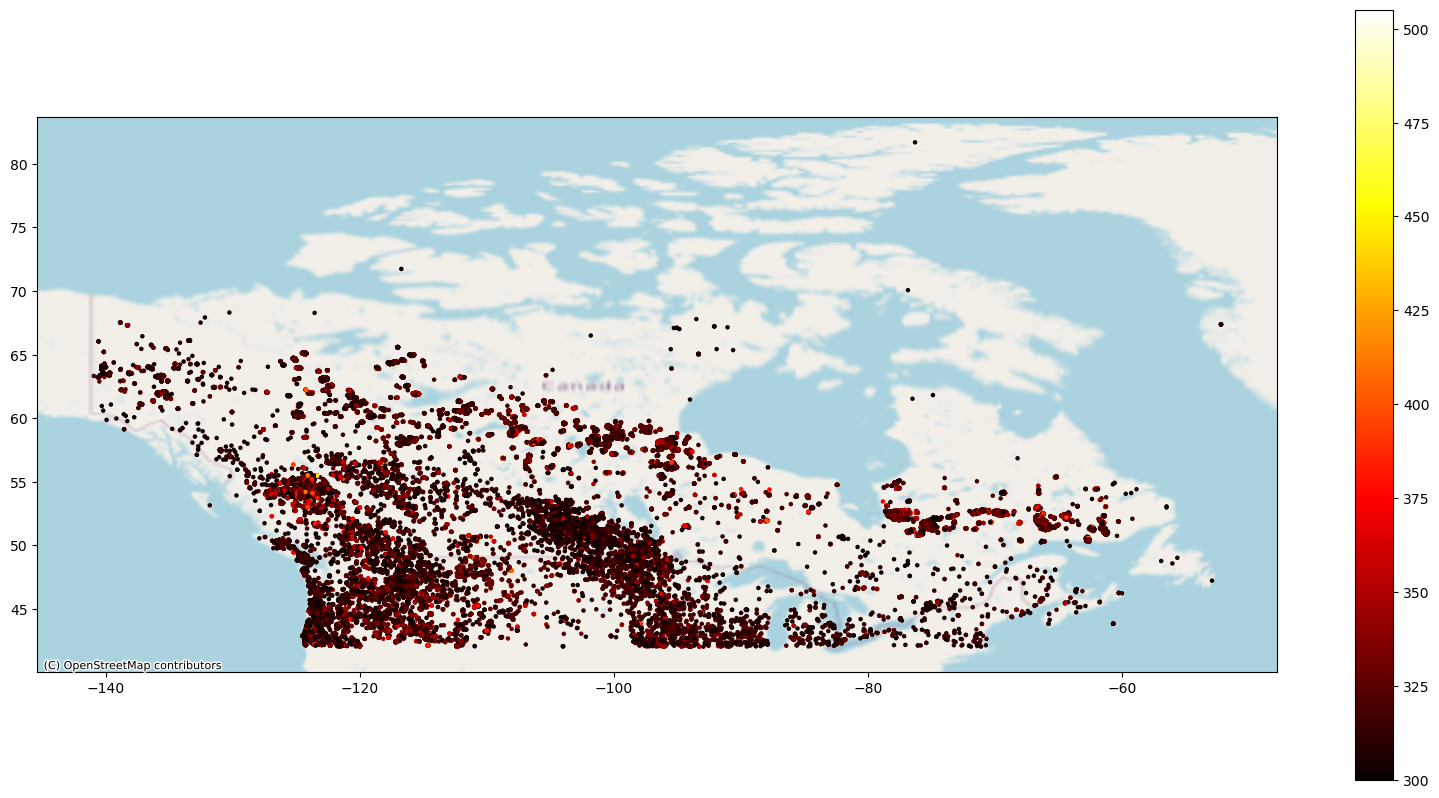

In [17]:

# Plot the fire intensity data on a map of the UK
fig, ax = plt.subplots(figsize=(20, 10))
fire_intensity_uk_gdf.plot(ax=ax, column='brightness', legend=True, cmap='hot', markersize=5)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)

# 3. Finding relationship| of FWI and Fire Intensity Data

# 3.1 Match daily FWI and Fire Intensity Data

In [41]:

fwi_uk_gdf.reset_index(inplace=True)

# Convert 'time' to datetime format and extract date
fwi_uk_gdf['time'] = pd.to_datetime(fwi_uk_gdf['time']).dt.date

# Ensure 'acq_date' is in date format
fire_intensity_uk_gdf['acq_date'] = pd.to_datetime(fire_intensity_uk_gdf['acq_date']).dt.date

# Rename columns for clarity
fire_intensity_uk_gdf.rename(columns={'acq_date': 'date'}, inplace=True)
fwi_uk_gdf.rename(columns={'time': 'date'}, inplace=True)

# Perform the spatial join on the same date
fire_intensity_uk_gdf = fire_intensity_uk_gdf.set_index('date')
fwi_uk_gdf = fwi_uk_gdf.set_index('date')

C:\Users\zhong\.conda\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\zhong\AppData\Local\Temp\ipykernel_17024\369051621.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_intensity_uk_gdf.rename(columns={'acq_date': 'date'}, inplace=True)


In [29]:
# Use KDTree
'''
1. For each date in fire_intensity_uk_gdf, subsets of fire_intensity_uk_gdf and fwi_uk_gdf are created.
2. cKDTree is built using the coordinates of fwi_subset.
3. The nearest neighbor for each point in fire_subset is found using the tree.
4. The result is a DataFrame where each row from fire_intensity_uk_gdf is matched with its nearest neighbor from fwi_uk_gdf for the same date, including the calculated distance.
5. If one row in fire_intensity_uk_gdf has same distance for multiple rows in fwi_uk_gdf: Generally, cKDTree will return the first occurrence of the nearest neighbor found in its internal tree structure. Assuming a left-to-right and top-to-bottom traversal, the row with Index 0 will be chosen if the distances are equal.
'''
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np

# Function to ensure GeoDataFrame has correct geometry and CRS
def ensure_geodataframe(df, crs="EPSG:4326"):
    if isinstance(df, pd.Series):
        df = pd.DataFrame([df])
    if not isinstance(df, gpd.GeoDataFrame):
        df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    if df.crs is None:
        df.set_crs(crs, inplace=True)
    return df

# Ensure both dataframes have the correct geometry and CRS
fire_intensity_uk_gdf = ensure_geodataframe(fire_intensity_uk_gdf)
fwi_uk_gdf = ensure_geodataframe(fwi_uk_gdf)

In [32]:
# Function to find nearest neighbors
def find_nearest(df1, df2, date):
    tree = cKDTree(np.c_[df2.geometry.x, df2.geometry.y])
    distances, indices = tree.query(np.c_[df1.geometry.x, df1.geometry.y], k=1)
    nearest_df2 = df2.iloc[indices].reset_index(drop=True)
    nearest_df2.columns = [f"{col}_nearest" for col in nearest_df2.columns]
    result = pd.concat([df1.reset_index(drop=True), nearest_df2, pd.Series(distances, name='distance')], axis=1)
    result['date'] = date
    return result

# Re-split and find nearest neighbors for each date
merged_dfs = []

for date in fire_intensity_uk_gdf.index.unique():
    if date in fwi_uk_gdf.index.unique():
        fire_subset = ensure_geodataframe(fire_intensity_uk_gdf.loc[[date]])
        fwi_subset = ensure_geodataframe(fwi_uk_gdf.loc[[date]])
        
        merged_dfs.append(find_nearest(fire_subset, fwi_subset, date))

# Concatenate all the merged DataFrames
merged_gdf = pd.concat(merged_dfs, ignore_index=True)

merged_gdf


,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,...,type,geometry,values_nearest,surface_nearest,latitude_nearest,longitude_nearest,fwinx_nearest,geometry_nearest,distance,date
0,51.4585,0.2016,300.6,1.0,1.0,1121,Terra,MODIS,40,6.03,...,2,POINT (0.20160 51.45850),59609,0.0,51.569065,0.0,0.664062,POINT (0.00000 51.56906),0.229928,2001-01-13
1,51.7088,-2.1441,300.2,1.0,1.0,1127,Terra,MODIS,32,6.03,...,0,POINT (-2.14410 51.70880),59609,0.0,51.569065,0.0,0.488281,POINT (0.00000 51.56906),2.148649,2001-01-20
2,56.0069,-3.6730,312.7,1.0,1.0,2215,Terra,MODIS,85,6.03,...,2,POINT (-3.67300 56.00690),47003,0.0,56.065548,0.0,NaN,POINT (0.00000 56.06555),3.673468,2001-01-24
3,53.5650,-0.5943,301.6,1.2,1.1,1145,Terra,MODIS,46,6.03,...,2,POINT (-0.59430 53.56500),53925,0.0,53.536276,0.0,0.433594,POINT (0.00000 53.53628),0.594994,2001-01-25
4,51.4635,0.2020,303.0,1.1,1.0,1134,Terra,MODIS,54,6.03,...,2,POINT (0.20200 51.46350),59609,0.0,51.569065,0.0,0.023438,POINT (0.00000 51.56906),0.227921,2001-01-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,51.4665,0.2048,303.2,1.0,1.0,1119,Terra,MODIS,55,6.03,...,2,POINT (0.20480 51.46650),59609,0.0,51.569065,0.0,0.496094,POINT (0.00000 51.56906),0.229047,2001-12-22
474,57.6640,1.1497,312.7,1.4,1.2,1052,Terra,MODIS,55,6.03,...,3,POINT (1.14970 57.66400),42646,0.0,57.751729,1.0,NaN,POINT (1.00000 57.75173),0.173512,2001-12-26
475,53.4047,-0.0979,302.3,1.8,1.3,1041,Terra,MODIS,52,6.03,...,0,POINT (-0.09790 53.40470),53925,0.0,53.536276,0.0,3.144531,POINT (0.00000 53.53628),0.164002,2001-12-28
476,53.5780,-0.6220,308.7,1.0,1.0,1124,Terra,MODIS,0,6.03,...,2,POINT (-0.62200 53.57800),53925,0.0,53.536276,0.0,0.273438,POINT (0.00000 53.53628),0.623398,2001-12-29


In [43]:
# Using sjoin_nearest


# Reproject to a common projected CRS for accurate distance calculations
fire_intensity_uk_gdf = fire_intensity_uk_gdf.to_crs("EPSG:4326")
fwi_uk_gdf = fwi_uk_gdf.to_crs("EPSG:4326") # EPSG:27700 will eliminate the warning

# Merge using sjoin_nearest for each date
sjoin_merged_dfs = []

for date in fire_intensity_uk_gdf.index.unique():
    if date in fwi_uk_gdf.index.unique():
        fire_subset = fire_intensity_uk_gdf.loc[[date]]
        fwi_subset = fwi_uk_gdf.loc[[date]]
        
        merged_df = gpd.sjoin_nearest(fire_subset, fwi_subset, how='left')
        merged_df['date'] = date
        sjoin_merged_dfs.append(merged_df)

# Concatenate all the merged GeoDataFrames
sjoin_merged_gdf = pd.concat(sjoin_merged_dfs, ignore_index=True)

sjoin_merged_gdf



C:\Users\zhong\.conda\envs\climada_env\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\zhong\.conda\envs\climada_env\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\zhong\.conda\envs\climada_env\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\zhong\.conda\envs\climada_env\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results f

,latitude_left,longitude_left,brightness,scan,track,acq_time,satellite,instrument,confidence,version,...,daynight,type,geometry,index_right,values,surface,latitude_right,longitude_right,fwinx,date
0,51.4585,0.2016,300.6,1.0,1.0,1121,Terra,MODIS,40,6.03,...,D,2,POINT (0.20160 51.45850),2001-01-13,59609,0.0,51.569065,0.0,0.664062,2001-01-13
1,51.7088,-2.1441,300.2,1.0,1.0,1127,Terra,MODIS,32,6.03,...,D,0,POINT (-2.14410 51.70880),2001-01-20,59609,0.0,51.569065,0.0,0.488281,2001-01-20
2,56.0069,-3.6730,312.7,1.0,1.0,2215,Terra,MODIS,85,6.03,...,N,2,POINT (-3.67300 56.00690),2001-01-24,47003,0.0,56.065548,0.0,NaN,2001-01-24
3,53.5650,-0.5943,301.6,1.2,1.1,1145,Terra,MODIS,46,6.03,...,D,2,POINT (-0.59430 53.56500),2001-01-25,53925,0.0,53.536276,0.0,0.433594,2001-01-25
4,51.4635,0.2020,303.0,1.1,1.0,1134,Terra,MODIS,54,6.03,...,D,2,POINT (0.20200 51.46350),2001-01-27,59609,0.0,51.569065,0.0,0.023438,2001-01-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,51.4665,0.2048,303.2,1.0,1.0,1119,Terra,MODIS,55,6.03,...,D,2,POINT (0.20480 51.46650),2001-12-22,59609,0.0,51.569065,0.0,0.496094,2001-12-22
474,57.6640,1.1497,312.7,1.4,1.2,1052,Terra,MODIS,55,6.03,...,D,3,POINT (1.14970 57.66400),2001-12-26,42646,0.0,57.751729,1.0,NaN,2001-12-26
475,53.4047,-0.0979,302.3,1.8,1.3,1041,Terra,MODIS,52,6.03,...,D,0,POINT (-0.09790 53.40470),2001-12-28,53925,0.0,53.536276,0.0,3.144531,2001-12-28
476,53.5780,-0.6220,308.7,1.0,1.0,1124,Terra,MODIS,0,6.03,...,D,2,POINT (-0.62200 53.57800),2001-12-29,53925,0.0,53.536276,0.0,0.273438,2001-12-29


In [49]:
script_sjoin_merged_gdf = gpd.read_file(os.path.join(save_path, 'merged_gdf'))


In [50]:
script_sjoin_merged_gdf

,latitude_left,longitude_left,brightness,satellite,instrument,confidence,bright_t31,frp,daynight,values,surface,latitude_right,longitude_right,fwi,date,geometry
0,51.4585,0.2016,300.6,Terra,MODIS,40,277.0,7.6,D,59609,0.0,51.569065,0.0,0.664062,2001-01-13,POINT (0.20160 51.45850)
1,51.7088,-2.1441,300.2,Terra,MODIS,32,274.0,8.1,D,59609,0.0,51.569065,0.0,0.488281,2001-01-20,POINT (-2.14410 51.70880)
2,56.0069,-3.6730,312.7,Terra,MODIS,85,273.6,17.8,N,47003,0.0,56.065548,0.0,NaN,2001-01-24,POINT (-3.67300 56.00690)
3,53.5650,-0.5943,301.6,Terra,MODIS,46,276.8,9.6,D,53925,0.0,53.536276,0.0,0.433594,2001-01-25,POINT (-0.59430 53.56500)
4,51.4635,0.2020,303.0,Terra,MODIS,54,277.6,10.4,D,59609,0.0,51.569065,0.0,0.023438,2001-01-27,POINT (0.20200 51.46350)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,51.4665,0.2048,303.2,Terra,MODIS,55,273.4,10.4,D,59609,0.0,51.569065,0.0,0.496094,2001-12-22,POINT (0.20480 51.46650)
474,57.6640,1.1497,312.7,Terra,MODIS,55,279.8,23.4,D,42646,0.0,57.751729,1.0,NaN,2001-12-26,POINT (1.14970 57.66400)
475,53.4047,-0.0979,302.3,Terra,MODIS,52,274.9,22.9,D,53925,0.0,53.536276,0.0,3.144531,2001-12-28,POINT (-0.09790 53.40470)
476,53.5780,-0.6220,308.7,Terra,MODIS,0,273.3,14.0,D,53925,0.0,53.536276,0.0,0.273438,2001-12-29,POINT (-0.62200 53.57800)


In [44]:
merged_gdf['fwinx_nearest'].equals(sjoin_merged_gdf['fwinx'])

True

In [56]:
merged_gdf['brightness'].equals(sjoin_merged_gdf['brightness'])

True

In [52]:
script_sjoin_merged_gdf['fwi'].equals(sjoin_merged_gdf['fwinx'])

False

In [74]:
print(script_sjoin_merged_gdf['fwi'][468])
print(sjoin_merged_gdf['fwinx'][468])
print(script_sjoin_merged_gdf['fwi'][468] == sjoin_merged_gdf['fwinx'][468])

nan
nan
False


In [72]:
# Find rows where the rounded columns are not equal
not_equal_bools = script_sjoin_merged_gdf['fwi'].fillna(0) != sjoin_merged_gdf['fwinx'].fillna(0)
print(len(script_sjoin_merged_gdf['fwi'][not_equal_bools]), len(sjoin_merged_gdf['fwinx'][not_equal_bools]))
not_equal_df = pd.DataFrame(script_sjoin_merged_gdf['fwi'][not_equal_bools], sjoin_merged_gdf['fwinx'][not_equal_bools])
not_equal_df

0 0


,fwi
fwinx,


In [53]:
script_sjoin_merged_gdf['brightness'].equals(sjoin_merged_gdf['brightness'])

True